# 🔬 Model Comparison & Submission – House Prices

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb

# Load cleaned training and test data
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [ ]:
import sys, os
sys.path.append(os.path.abspath('../src'))
from preprocess import preprocess

train, encoder, cat_cols = preprocess(train, is_train=True)
test = preprocess(test, is_train=False, ordinal_encoder=encoder, cat_cols=cat_cols)

X = train.drop("SalePrice", axis=1)
y = train["SalePrice"]
X_test = test[X.columns]


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# Prepare train and test datasets
X = train.drop(['SalePrice'], axis=1)
y = train['SalePrice']

# Match test columns to training (drop SalePrice if exists)
X_test = test[X.columns] if 'SalePrice' not in test.columns else test.drop(['SalePrice'], axis=1)

## 📊 Cross-Validation Comparison

In [ ]:
# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean()

models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    score = rmse_cv(model)
    results[name] = score
    print(f"{name}: RMSE = {score:.2f}")

Ridge: RMSE = 37749.84
RandomForest: RMSE = 30560.20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3385
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 74
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3381
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Info] Start training from score 179651.292808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_

## 🏁 Train Final Model & Predict

## 📈 Model Performance Comparison

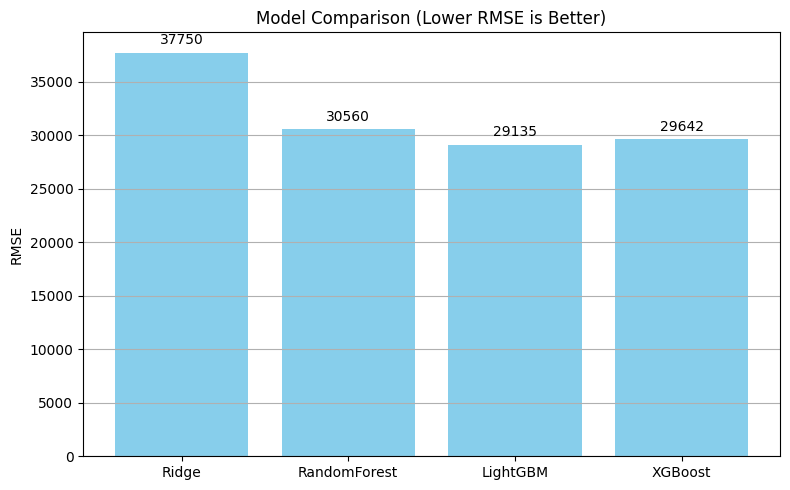

In [ ]:
# Visualize model RMSE scores
import matplotlib.pyplot as plt

model_names = list(results.keys())
rmse_scores = list(results.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, rmse_scores, color='skyblue')
plt.title('Model Comparison (Lower RMSE is Better)')
plt.ylabel('RMSE')
plt.grid(axis='y')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 500, f'{yval:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Choose the best model (LightGBM in this case)
final_model = lgb.LGBMRegressor(random_state=42)
final_model.fit(X, y)
preds = final_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 75
[LightGBM] [Info] Start training from score 180921.195890


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: MSZoning: object, Street: object, Alley: object, LotShape: object, LandContour: object, Utilities: object, LotConfig: object, LandSlope: object, Neighborhood: object, Condition1: object, Condition2: object, BldgType: object, HouseStyle: object, RoofStyle: object, RoofMatl: object, Exterior1st: object, Exterior2nd: object, MasVnrType: object, ExterQual: object, ExterCond: object, Foundation: object, BsmtQual: object, BsmtCond: object, BsmtExposure: object, BsmtFinType1: object, BsmtFinType2: object, Heating: object, HeatingQC: object, CentralAir: object, Electrical: object, KitchenQual: object, Functional: object, FireplaceQu: object, GarageType: object, GarageFinish: object, GarageQual: object, GarageCond: object, PavedDrive: object, PoolQC: object, Fence: object, MiscFeature: object, SaleType: object, SaleCondition: object

## 💾 Save Submission

In [ ]:
# Prepare submission file
submission = sample_submission.copy()
submission['SalePrice'] = preds
submission.to_csv('../data/submission.csv', index=False)
print('✅ Submission saved to ../data/submission.csv')